# Light Curves from the computed flux points

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from astropy.time import Time

In [2]:
#from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?

from gammapy.data import DataStore
from gammapy.irf import PSFKernel
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import MapDataset, Datasets, FluxPointsDataset
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    TemplateSpatialModel,
    GaussianSpatialModel,
    FoVBackgroundModel
)
#from gammapy.stats import significance, excess # utiles ?
from gammapy.estimators import (
    #LiMaMapEstimator,
    TSMapEstimator,
    ExcessMapEstimator,
    FluxPointsEstimator
)


import gammapy
gammapy.__version__

'0.18.2'

In [3]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

In [4]:
from pathlib import Path

# Directory for outputs

path = Path("../../../hess_results/GC_variability_0.18.2/hap-hd")
path.mkdir(exist_ok=True)

pathma = Path(path/"mapdatasets")
pathma.mkdir(exist_ok=True)

pathmo = Path(path/"models")
pathmo.mkdir(exist_ok=True)

# for consistency we will use the template using exp cutoff for both the central source and the DE
# but it will generally require that the cutoff of the DE be frozen and set to infinity (lambda = 0)

model_name = pathmo/"models_template_2cutoff.yaml" 

pathres = Path(path/"1cutoff_time_analysis_bis")
pathres.mkdir(exist_ok=True)

In [5]:
emin, emax = [0.5, 100] * u.TeV

e_bins = 20

energy_axis = MapAxis.from_energy_bounds(
    emin.value, emax.value, e_bins, unit="TeV"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
)

emintrue, emaxtrue = [0.3,200] * u.TeV
e_bins_true = 30

energy_axis_true = MapAxis.from_energy_bounds(
    emintrue.value, emaxtrue.value, e_bins_true, unit="TeV", name="energy_true"
)

## Creating the datasets

In [6]:
datasets_year = Datasets.read(pathma/"datasets_year.yaml")

## Reading the model template

In [7]:
modelGC,modelG09, modeldiff= Models.read(model_name)

In [8]:
# if needed
modelGC.parameters["amplitude"].frozen = False
modelGC.parameters["amplitude"].value = 3.0e-12

modelGC.parameters["index"].frozen = True
modelGC.parameters["index"].value = 1.87

modelGC.spectral_model.parameters['lambda_'].frozen = True
modelGC.spectral_model.parameters['lambda_'].value = 1/7.9

modeldiff.parameters["amplitude"].frozen = False
modeldiff.parameters["amplitude"].value = 3.0e-12

modeldiff.parameters["index"].frozen = True
modeldiff.parameters["index"].value = 2.32

modeldiff.spectral_model.parameters['lambda_'].frozen = True
modeldiff.spectral_model.parameters['lambda_'].value = 0.0

## Constructing the mask

In [9]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 2*u.deg)

J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.5 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([J1745_303_region] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

## Applying the mask and the model template

In [10]:
for year in range(2004,2020):
    datasets_year[f'map_{year}'].fit_mask = fit_mask
    bkg_model = FoVBackgroundModel(dataset_name=f"map_{year}")
    datasets_year[f'map_{year}'].models =  [modelGC.copy(),modelG09.copy(),modeldiff.copy(),bkg_model]

## Flux points

One alternative way to assess spectral variability over the years is to compute flux points for each year (but on quite large energy bins since we will lack the data to compute more than a few points).

In [11]:
def FluxPointsFitting(dataset, e_edges):
    # this function has to be given the number of the source model in case of multiple models
    # more parameters exist to initialise the estimator
    
    fpe = FluxPointsEstimator( energy_edges=e_edges, source =0) 
    flux_points = fpe.run(datasets=[dataset]) 
    return flux_points

In [12]:
e_edges = np.array([0.5,1,2,5,10]) * u.TeV

In [13]:
years = [k for k in range(2004,2020)]

In [14]:
flux_years = {0 : [], 1 : [], 2 : [], 3 : []}

for year in years:
    flux_points = FluxPointsFitting(datasets_year[f"map_{year}"], e_edges)
    for k in range(len(e_edges) - 1):
        flux_years[k].append(flux_points.table[k])

HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found


In [16]:
import scipy.stats as stats

from astropy.modeling import models, fitting

from scipy.stats import chisquare, chi2

# chi2 non réduit
def chisq(obs, exp, error):
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    return chisq

# chi2 réduit
def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp)**2)/(error[i]**2)
    return chisqr/(len(obs) -1)

def pval(obs, exp, error, nddl): # number of DoF is the number of points minus number of fitted parameters (1 for a constant)
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    pval = 1 - chi2.cdf(chisq, nddl)
    return pval

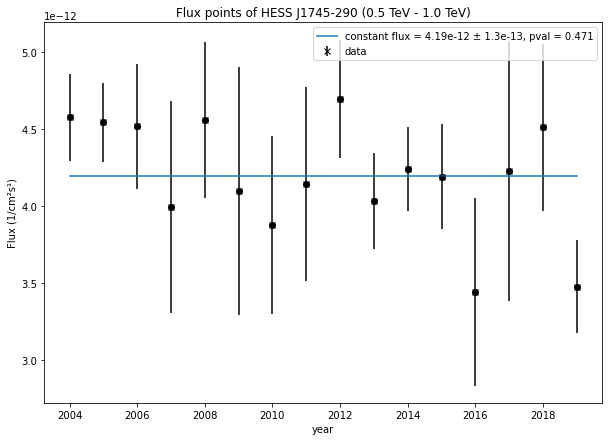

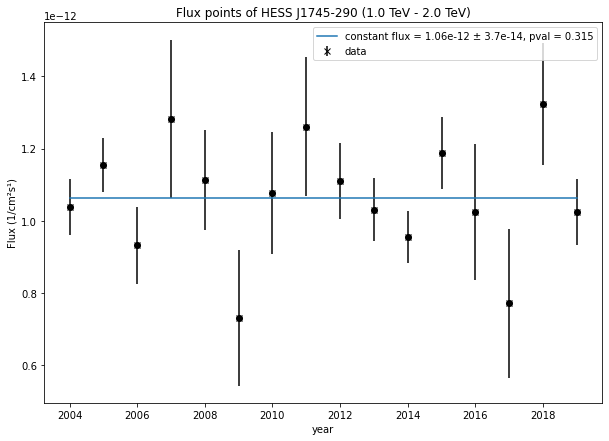

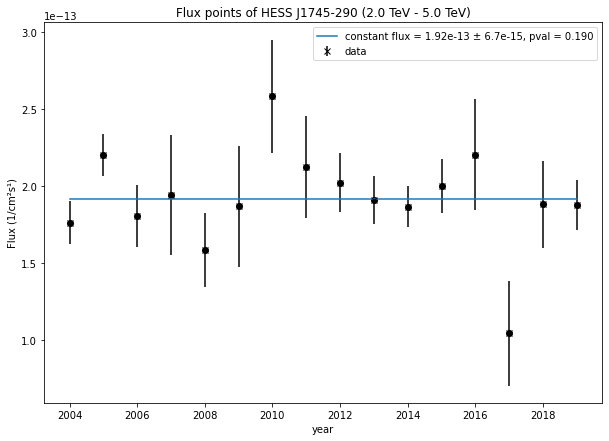

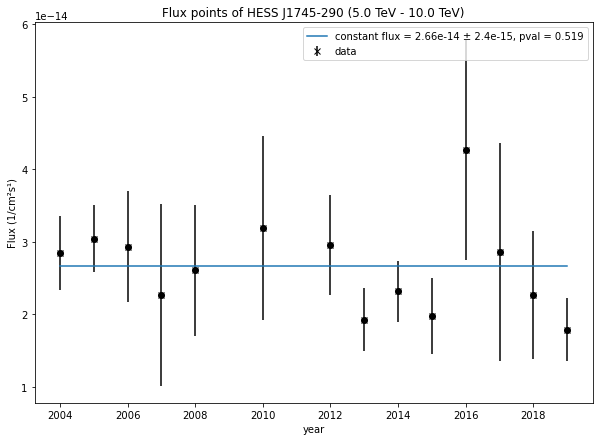

In [39]:
#problem for 2009 and 2011

for k in range(len(e_edges) - 1) :
    y = []
    y_uncs = []
    years = [k for k in range(2004,2020)]
    

    
    for l,year in zip(range(len(years)),years):
        if k!=3 or (k==3 and (year!=2009 and year!=2011)):
            y.append(flux_years[k][l]['dnde'])
            y_uncs.append(flux_years[k][l]['dnde_err'])
    
    if k == 3:
        years.remove(2009)
        years.remove(2011)
    x = years

    
    t_init = models.Const1D(1e-12)
    fit_t = fitting.LevMarLSQFitter()
    t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

    A1 = y
    A2 = t(2004)
    err_bars = y_uncs
    
    pv = pval(A1, A2, err_bars, len(A1)-1)
    
    error_const = np.sqrt(sum([a**2 for a in err_bars]))/len(A1)

    # Plot the data with the best-fit model
    plt.figure(figsize=(10,7))
    plt.plot(x, y, 'ko')
    plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
    plt.plot(x, t(x), label=f"constant flux = {A2:0.2e} ± {error_const:0.1e}, pval = {pv:0.3f}")
    
    plt.xlabel('year')
    plt.ylabel('Flux (1/cm²s¹)')
    
    plt.legend(loc=1)
    
    plt.title("Flux points of HESS J1745-290 ("+str(e_edges[k]) +" - "+ str(e_edges[k+1])+")")
    name = "GC_FP_bin"+str(k)+"_hd.pdf"
    plt.savefig(pathres/name)

In [27]:
flux_years[3][5]

counts [1],e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,ts,norm_errp,norm_errn,norm_ul,norm_scan [11],stat_scan [11],sqrt_ts,dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
125,7.071067910277233,5.425421714782715,9.215873718261717,3.161254843595759e-14,1.215104325028236e-13,8.344460053436959e-13,1.580627465794721e-12,-56.06596413452644,1674.2892681165408,True,36.538369343037715,136.43363537270307,29.105143693228644,38.323012694497905,-20.433504123869312,0.20000000000000004 .. 5.000000000000001,1807.779020379651 .. 1849.1632005854492,-11.680480956394863,-1.7723880068113783e-12,-6.459551388321578e-13,1.1550709706276877e-12,9.200877647376961e-13,1.2114880950166327e-12


In [38]:
len(y)

16